In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import bike_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible
from training_callback import BatchMSE

In [4]:
X_train, X_test, y_train, y_test = bike_prep()

In [5]:
# use samller dataset for increased speed
X_train = X_train[:1000]
X_test = X_test[:500]
y_train = y_train[:1000]
y_test = y_test[:500]

n_cols = X_train.shape[1]

In [6]:
particles = 3
early_stopping = 0.001
batch_normal = False # noch einbauen, aber Achtung mit den Dimensionen unten!!!
shuffle = True

In [7]:
layers = 5
neurons = [64, 32, 32, 16, 1]
n_cols = X_train.shape[1]
batch_size = 32
epochs = 5

In [8]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [9]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [10]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [11]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [14]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 873us/step - loss: 66411.4375 - mse: 66411.4375
66411.4375
16/16 [==============================] - 0s 806us/step - loss: 66964.4453 - mse: 66964.4453
66964.4453125
16/16 [==============================] - 0s 795us/step - loss: 66130.4609 - mse: 66130.4609
66130.4609375


In [15]:
model_dict["model_1"].predict(X_test).ravel()

array([-0.47872955, -0.511487  , -0.42715484, -0.48712772, -0.46620053,
       -0.5026307 , -0.35378993, -0.46760172, -0.48110506, -0.58408266,
       -0.5765587 , -0.44448945, -0.5164765 , -0.5060588 , -0.46371466,
       -0.49161887, -0.55356497, -0.5305277 , -0.4989056 , -0.44920608,
       -0.49841318, -0.5468869 , -0.5253587 , -0.44356123, -0.5410129 ,
       -0.50543875, -0.46908674, -0.4691642 , -0.5358598 , -0.47555184,
       -0.52610934, -0.66956687, -0.48787743, -0.37061036, -0.45226723,
       -0.5068594 , -0.3432906 , -0.5205811 , -0.4697257 , -0.47698972,
       -0.45780292, -0.47396708, -0.40968627, -0.49542427, -0.40776315,
       -0.526463  , -0.48711234, -0.4591254 , -0.4986636 , -0.4978826 ,
       -0.49697086, -0.5144859 , -0.49164724, -0.46483797, -0.5059922 ,
       -0.55      , -0.49043202, -0.47152078, -0.4926811 , -0.45892453,
       -0.5360638 , -0.50750875, -0.44052416, -0.4764443 , -0.45755547,
       -0.4982125 , -0.44433403, -0.49109983, -0.4724952 , -0.53

In [16]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = 1/len(y_batches[b]) * (-2)*(y_batches[b] - y_pred_dict["model_{}".format(str(i+1))].ravel())
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        #print(y_pred_dict["model_1"])
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.dot(y_pred_centered.ravel(), jacobian_dict["model_{}".format(str(j+1))])
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))

In [17]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 745us/step - loss: 66924.5391 - mse: 66924.5391
66924.5390625
16/16 [==============================] - 0s 997us/step - loss: 66553.5625 - mse: 66553.5625
66553.5625
16/16 [==============================] - 0s 908us/step - loss: 66138.3984 - mse: 66138.3984
66138.3984375


In [24]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [25]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 830us/step - loss: 66478.1016 - mse: 66478.1016


[66478.1015625, 66478.1015625]

In [18]:
model_dict["model_1"].get_weights()

[array([[ 0.18360597,  0.022454  ,  0.12975092, ...,  0.0927804 ,
          0.13099273, -0.26845765],
        [-0.01268142,  0.18863858,  0.04429561, ...,  0.5081108 ,
         -0.02412708,  0.3116532 ],
        [ 0.06836764,  0.22700316, -0.04966023, ...,  0.07185508,
         -0.10577945,  0.15329163],
        ...,
        [-0.38343355, -0.00320738, -0.2286397 , ..., -0.22235315,
          0.27801573, -0.08232591],
        [-0.07971447,  0.05779862,  0.02084918, ...,  0.17779309,
          0.42194882, -0.19201313],
        [ 0.03048011, -0.11129764, -0.025444  , ...,  0.05233171,
          0.04826559, -0.25867543]], dtype=float32),
 array([ 0.18422544,  0.06601666,  0.23378216, -0.09825441, -0.01555302,
        -0.03161227,  0.13647   ,  0.37561738, -0.05155   ,  0.363177  ,
        -0.04308495, -0.18380335,  0.16644965,  0.11196081,  0.00572907,
        -0.22127123, -0.27903196, -0.02440498,  0.23455556,  0.18083887,
         0.1324117 , -0.10937811, -0.0640647 , -0.00842765, -0.037

In [19]:
y_pred_dict["model_1"]

array([[-1.2538965 ],
       [-1.3301928 ],
       [-0.06830102],
       [-2.8859062 ],
       [-0.20925683],
       [-1.7674813 ],
       [-2.0626311 ],
       [-3.1697261 ]], dtype=float32)

In [20]:
jacobian_dict["model_1"]

array([-104.56347412,   -3.3325482 ,  -33.01707526,  -52.47147655,
        -35.30231421, -195.19187033,   -2.51565778, -101.79243153])

In [21]:
train_mse_dict

{'model_1': [73259.7734375,
  73353.703125,
  72979.1953125,
  73643.2421875,
  73063.2265625,
  73683.1171875,
  72971.5546875,
  73680.3671875,
  73101.3359375,
  73758.6953125,
  73019.1484375,
  73701.3828125,
  72979.3125,
  73775.890625,
  72930.5078125,
  73784.2890625,
  72935.90625,
  73797.46875,
  72932.7265625,
  73774.234375,
  72947.3046875,
  73751.4921875,
  73039.3828125,
  73898.09375,
  72992.203125,
  73853.921875,
  73020.2734375,
  73802.328125,
  73020.6171875,
  73765.34375,
  72964.3203125,
  73811.09375,
  72997.3984375,
  73835.6171875,
  72976.59375,
  73877.0234375,
  72964.1953125,
  73820.703125,
  72983.4296875,
  73826.6953125,
  72989.5703125,
  73819.59375,
  72979.9296875,
  73843.7890625,
  72966.96875,
  73814.8515625,
  73012.9453125,
  73713.5546875,
  73036.3984375,
  73798.78125,
  72962.9609375,
  73812.7578125,
  72978.765625,
  73829.203125,
  72962.265625,
  73825.6484375,
  72998.4765625,
  73761.5859375,
  73025.9765625,
  73787.34375,
  

In [22]:
test_mse_dict

{'model_1': [66411.4375,
  66502.03125,
  66141.5234375,
  66772.3984375,
  66222.6328125,
  66806.703125,
  66134.6796875,
  66805.4921875,
  66259.609375,
  66872.9609375,
  66180.40625,
  66825.6796875,
  66142.2890625,
  66891.125,
  66095.484375,
  66899.25,
  66100.6953125,
  66911.515625,
  66097.734375,
  66892.28125,
  66111.7421875,
  66873.4765625,
  66200.28125,
  66996.453125,
  66154.9140625,
  66964.25,
  66181.953125,
  66922.5625,
  66182.3046875,
  66890.9296875,
  66128.15625,
  66932.3671875,
  66159.96875,
  66955.359375,
  66139.9375,
  66993.34375,
  66128.0390625,
  66945.2109375,
  66146.5390625,
  66951.3828125,
  66152.4453125,
  66945.421875,
  66143.171875,
  66968.890625,
  66130.71875,
  66942.234375,
  66174.953125,
  66846.140625,
  66197.546875,
  66928.0703125,
  66126.8828125,
  66941.9296875,
  66142.0859375,
  66958.3125,
  66126.2109375,
  66955.53125,
  66161.0390625,
  66893.8203125,
  66187.515625,
  66918.9453125,
  66159.9296875,
  66958.2656

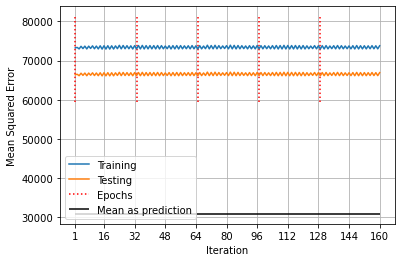

In [23]:
nn_plot_iter_mse(train_mse_dict["model_1"],
                 test_mse_dict["model_1"],
                 iteration_dict["model_1"],
                 mse_mean = mean_squared_error(y_test, np.ones(shape = (len(y_test),))*np.mean(y_test)))

## Jetzt mit dem ursprünglichen EnKF-Algorithmus wie für inverse Probleme

#### Problem: 
$C^{ww}$ ist singuläre Matrix und kann nicht invertiert werden. Mit der Pseudoinversen kommt der Error "SVD did not converge" und dieser Error für kleinere Gamma-Diagonalmatrizen später. Obwohl sich der MSE verringert, ist er dennoch mit $10^{23}$ viel zu groß, als dass das so Sinn ergeben würde.

In [200]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [201]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [202]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the parameters
        weights_mean = np.mean(list(weights_dict.values()), axis = 0)
        mean_array = np.array([])
        for i in range(weights_mean.shape[0]):
            mean_array = np.append(mean_array, np.reshape(weights_mean[i], (1, -1)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
                                       
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
            
        # compute the 
        weight_diff_dict = {}
        pred_diff_theta_dict = {}
        pred_diff_w_dict = {}
        c_theta_w_dict = {}
        c_w_w_dict = {}
        for i in range(particles):
            weight_diff_dict["model_{}".format(str(i+1))] = weights_vector_dict["model_{}".format(str(i+1))] - mean_array
            pred_diff_theta_dict["model_{}".format(str(i+1))] = y_pred_dict["model_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["model_{}".format(str(i+1))] = y_pred_dict["model_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            weight_diff_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(weight_diff_dict["model_{}".format(str(i+1))], (pred_diff_theta_dict["model_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_theta_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(pred_diff_theta_dict["model_{}".format(str(i+1))], (1, weight_diff_dict["model_{}".format(str(i+1))].shape[0])))
            pred_diff_w_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(pred_diff_w_dict["model_{}".format(str(i+1))], (1, pred_diff_w_dict["model_{}".format(str(i+1))].shape[0])))
            c_theta_w_dict["model_{}".format(str(i+1))] = np.multiply(weight_diff_dict["model_{}".format(str(i+1))], pred_diff_theta_dict["model_{}".format(str(i+1))])
            c_w_w_dict["model_{}".format(str(i+1))] = np.multiply(pred_diff_w_dict["model_{}".format(str(i+1))], pred_diff_w_dict["model_{}".format(str(i+1))])
        c_theta_w = np.mean(list(c_theta_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)
          
        # matrix with particle parameters as row vectors
        # weights_all_ptcls = np.array(list(weights_vector_dict.values()))
        for i in range(particles):
            print(i)
        # compute the matrix with the updates for each particle
            weights_vector_dict["model_{}".format(str(i+1))] = weights_vector_dict["model_{}".format(str(i+1))] + np.dot(np.dot(c_theta_w, np.linalg.pinv(c_w_w + np.diag(np.ones(c_w_w.shape[0])*0.1))), y_batches[b] - y_pred_dict["model_{}".format(str(i+1))].ravel())
            
        for i in range(particles):
            # write the updates back into the dictionary
            # weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0


LinAlgError: SVD did not converge

In [203]:
train_mse_dict

{'model_1': [73296.65625,
  2.4969754563337172e+29,
  8.685839227209173e+28,
  2.6281990650024244e+28,
  1.6774792581632795e+28,
  9.368100763638523e+27,
  7.570069760314682e+27,
  6.838308968707702e+27,
  5.201792343830968e+27,
  4.159821659147523e+27,
  2.860386963522214e+27,
  2.1973047282672284e+27,
  1.90986549607535e+27,
  1.8805995152414808e+27,
  1.7100934558630842e+27,
  1.645441307233547e+27,
  1.1585233380601748e+27,
  1.085109871439341e+27,
  1.0589205861560378e+27,
  8.862726384297547e+26,
  7.515354061060913e+26,
  6.1594777888062986e+26,
  5.396617852726381e+26,
  5.053409538407148e+26,
  4.993676029617425e+26,
  4.749634091024521e+26,
  4.568943436669077e+26,
  4.3524173994062816e+26,
  3.944121593297372e+26,
  3.6925559656665655e+26,
  3.505103472803462e+26,
  3.1865112316459505e+26,
  1.8741434499635876e+26,
  1.5034430306141019e+26,
  1.3392295614676172e+26,
  1.3210573049457245e+26,
  1.2269427545514213e+26,
  1.179322945893742e+26,
  1.1416724033695378e+26,
  9.421

In [ ]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [ ]:
init_model.evaluate(X_test, y_test)